# Preliminary analysis of variation in Gerosa to decide CoV thresholds in ML

In ML, the features will be filtered based on their CoV (coefficient of variation). Because the data is splitted into training and test data before feature selection is applied, only 7 of the 8 samples will be avaialable when calculating CoV. The results in this Notebook, which uses all 8 samples, are therefore just an indication of the degree of filtering the different CoV thresholds will give. 

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this Notebook
folder_path_figures = 'Figures/'
figure_format = 'pdf'
plt.style.use('ggplot')

In [4]:
#update math text font to match latex
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Charter' #same font as in Latex document
plt.rcParams['mathtext.it'] = 'Serif:italic' #closest to Latex font (couldn't find Charter italic font)
plt.rcParams['mathtext.bf'] = 'Serif:bold' #cloeset to Latex font (couldn't find Charter bold font)

## Load and clean data

In [5]:
#load data
gexp_g, flux_g = load_gerosa()

#clean (remove duplicated genes)
gexp_g, duplicates = clean_gexp_g(gexp_g)

In [6]:
#targets to look at correlation with
chosen_targets = ['R_PPC', 'R_AKGDH', 'R_ICDHyr']

## Get high correlations

In [7]:
#calcualte gene-reaction correlations with chosen targets
#use absolute fluxes because amount of required enzyme is independent of flux direction
corr = get_all_correlations(gexp_g, flux_g.abs()[chosen_targets], column_names = ['gene', 'reaction', 'r'] )

In [8]:
#get the genes with the highest absolute correlations
threshold = 0.9
#get absolute correlations
corr_abs = corr.copy()
corr_abs['r'] = corr_abs['r'].abs()
#extract rows with absolute correlation above threshold
corr_highest = corr_abs[corr_abs['r'] > threshold]
#extract the genes involved in correlations above threshold
corr_genes = corr_highest['gene'].unique()

## Investigate different thresholds

In [9]:
#calculate CoV
cov_g = gexp_g.std(axis=0)/gexp_g.mean(axis=0)

#thresholds to test
cutoff = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 2.5, 3]

### All genes

In [10]:
size_g = gexp_g.shape[1]
print('Gerosa original size:', size_g)
for p in cutoff:
    left = gexp_g.loc[:, cov_g > p].shape[1]
    removed = size_g-left
    print('%.2f:\t%.d removed\t%.d left'  % (p,removed, left))

Gerosa original size: 4105
0.10:	54 removed	4051 left
0.20:	913 removed	3192 left
0.25:	1543 removed	2562 left
0.30:	2131 removed	1974 left
0.40:	2949 removed	1156 left
0.50:	3402 removed	703 left
0.60:	3666 removed	439 left
0.70:	3840 removed	265 left
0.80:	3931 removed	174 left
0.90:	3993 removed	112 left
1.00:	4021 removed	84 left
1.10:	4041 removed	64 left
1.20:	4056 removed	49 left
1.30:	4066 removed	39 left
1.50:	4077 removed	28 left
2.00:	4083 removed	22 left
2.50:	4101 removed	4 left
3.00:	4105 removed	0 left


### Highly correlated genes

In [11]:
size_g_high_corr = len(corr_genes)

print('Gerosa highly correlated original size:', size_g_high_corr)
for p in cutoff:
    left = gexp_g[corr_genes].loc[:, cov_g > p].shape[1]
    removed = size_g_high_corr-left
    print('%.2f: \t%s removed \t%s left'  % (p, removed, left))

Gerosa highly correlated original size: 384
0.10: 	1 removed 	383 left
0.20: 	47 removed 	337 left
0.25: 	92 removed 	292 left
0.30: 	145 removed 	239 left
0.40: 	237 removed 	147 left
0.50: 	307 removed 	77 left
0.60: 	347 removed 	37 left
0.70: 	368 removed 	16 left
0.80: 	378 removed 	6 left
0.90: 	382 removed 	2 left
1.00: 	383 removed 	1 left
1.10: 	383 removed 	1 left
1.20: 	383 removed 	1 left
1.30: 	383 removed 	1 left
1.50: 	383 removed 	1 left
2.00: 	383 removed 	1 left
2.50: 	384 removed 	0 left
3.00: 	384 removed 	0 left


### Histograms

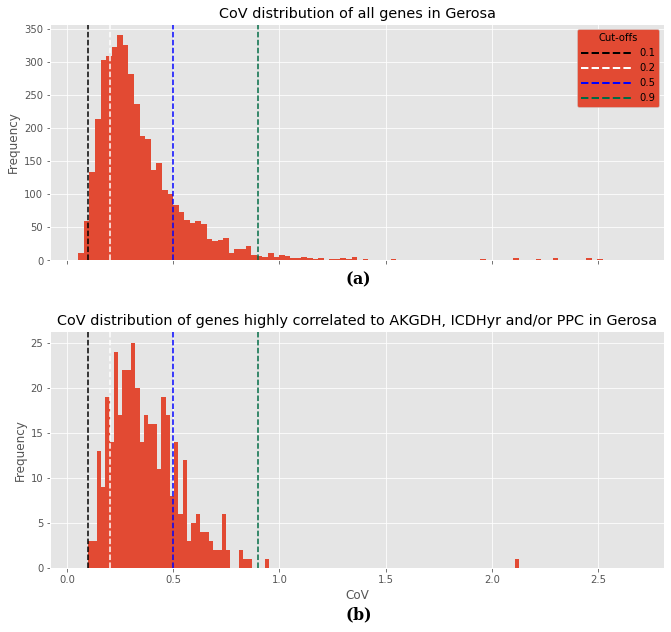

In [12]:
#settings
figure_name = 'cov_histograms'
suptitle = 'Distribution of coefficiant of variation in Gerosa transcriptomic data'
xlabel = 'CoV'
#xlabel = 'Coefficient of variation'
title_all = 'CoV distribution of all genes in Gerosa'
title_corr = 'CoV distribution of genes highly correlated to AKGDH, ICDHyr and/or PPC in Gerosa'

guide_lines = [0.1,
               0.2,
               0.5,
               0.9]
guide_colors = ['black',
                'white',
                'blue',
                '#006b44',
               ]

fig, ((ax1),(ax2)) = plt.subplots(2,1, figsize = (11,10), sharex = True)

#-------------------------- plot all genes------------------------------------------

ax = ax1
cov_g.plot.hist(bins = 100, ax = ax)
ax.set_xlabel(xlabel)
ax.set_title(title_all)
for guide_line, guide_color in zip(guide_lines, guide_colors):
    ax.axvline(guide_line, color = guide_color,linestyle='--')
    
#-------------------------- plot all highly correlated genes -----------------------

ax = ax2
cov_g[corr_genes].plot.hist(bins = 100, ax = ax)
ax.set_xlabel(xlabel)
ax.set_title(title_corr)
for guide_line, guide_color in zip(guide_lines, guide_colors):
    ax.axvline(guide_line, color = guide_color,linestyle='--')

#-------------------------- plot common legend and title ---------------------------

custom_lines = []
explanations = []
for guide_line, guide_color in zip(guide_lines, guide_colors):
    custom_lines.append(Line2D([0], [0], color=guide_color, lw=2, linestyle = '--')),
    explanations.append(str(guide_line))
                        
legend = ax1.legend(custom_lines,
                    explanations,
                    title = 'Cut-offs',
                    labelcolor = 'black',
                    handlelength = 5,
                    facecolor = '#E24A33',
                    framealpha=1,
                  )
plt.setp(legend.get_title(), color='black')
#plt.suptitle(suptitle, weight = 'bold', y = 0.95)
plt.subplots_adjust(wspace=0.2, hspace=0.3) #width and height between subplots

#-------------------------- Number the plots ---------------------------------------
#add plot numbering
first = True
for ax in fig.axes:
    if (first):
        ax.text(
            .48,-0.04, #below
            #-.15,0.5, #left
             r'$\bf{(a)}$', #+ ' ' + 'All genes', 
             transform=ax.transAxes,
             fontsize=16, 
             family = 'serif',
             fontname = 'Charter',
             va='top',
             #fontweight = 'bold',
            )
        first = False
    else:
        ax.text(
            .48,-0.16, #below
            #-.15,0.5, #left
             r'$\bf{(b)}$', #+ ' ' + 'Genes highly correlated to PPC, AKGDH and/or ICDHyr', 
             transform=ax.transAxes,
             fontsize=16, 
             family = 'serif',
             fontname = 'Charter',
             va='top',
             #fontweight = 'bold',
           )

#-------------------------- save figure --------------------------------------------

plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

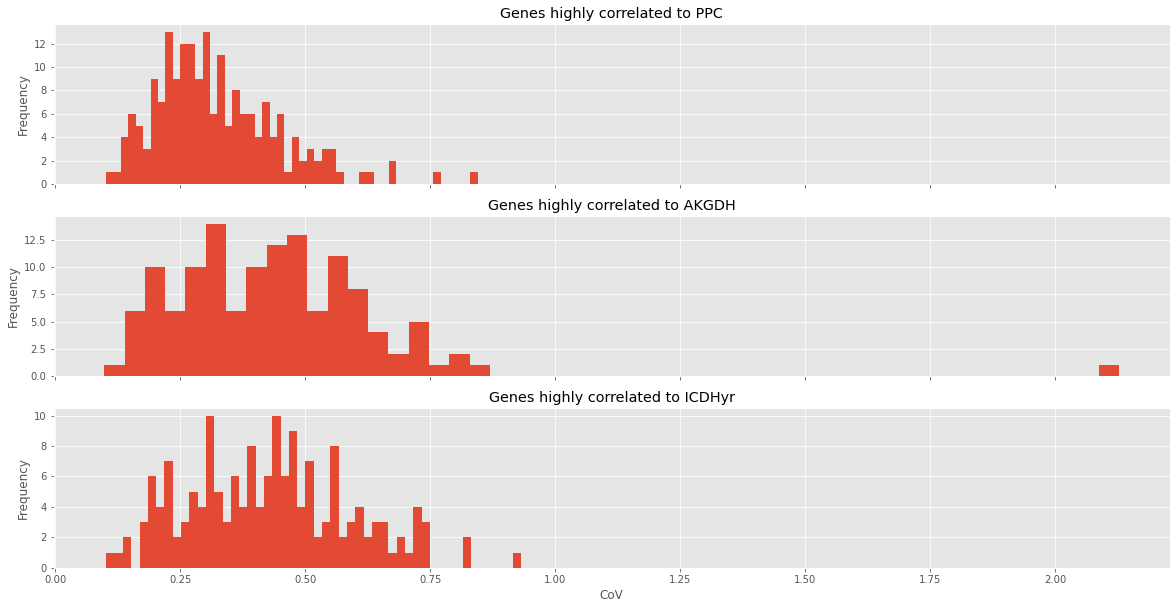

In [13]:
#cov distributionof highly correlated genes to the individual reactions
fig, axes = plt.subplots(3,1, sharex = True, figsize = (20,10))
for ax, target in zip(fig.axes, ['R_PPC', 'R_AKGDH', 'R_ICDHyr']):
    reaction_cov = corr_highest[corr_highest['reaction'] == target]
    cov_g[reaction_cov['gene'].unique()].plot.hist(bins = 50, ax = ax)
    ax.set_title('Genes highly correlated to ' + target[2:])
    ax.set_xlabel('CoV')